# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [2]:
import os
from collections import Counter
import numpy as np
import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from datetime import datetime
from numba import jit
from itertools import chain

In [3]:
def read_corpus(path=os.path.join('data', 'text8.txt')):
    '''
    Функция читает файл с текстом, преобразует его в список слов.
    '''
    with open(path, 'r') as f:
        corpus = f.read().split()
    return corpus

def read_and_transform_corpus(path=os.path.join('data', 'text8.txt'), vocab_sz = 20000):
    '''
    Функция читает файл с текстом, преобразует его в список слов.
    Заменяет редкие слова (не входящие в топ vocab_sz) на 'UNK'.
    '''
    corpus = read_corpus(path)
    words_counter = Counter(corpus)
    words_to_keep = set([pair[0] for pair in words_counter.most_common(
                    min(vocab_sz-1, len(words_counter)))]
    )
    corpus = [word if word in words_to_keep else 'UNK' for word in corpus]
    return corpus

def build_vocabulary(corpus):
    '''
    Функция возвращает два словаря: слово-индекс и индекс-слово.
    '''
    corpus_words = set(corpus)
    num_corpus_words = len(corpus_words)
    index2word = dict(enumerate(corpus_words))
    word2index = dict(zip(index2word.values(), index2word.keys()))
    return word2index, index2word

def corpus_to_index(corpus, word2index):
    '''
    Функция преобразует список слов из корпуса в список индексов.
    '''
    return [word2index[word] for word in corpus]

In [4]:
@jit(nopython=True)
def rand_choice_neg_words(V_arr, prob, num):
    """
    :param V_arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return V_arr[np.searchsorted(np.cumsum(prob), np.random.random(num), side="right")]

In [5]:
def batcher(corpus, p_keep, p_neg, num_neg_for_window, V_arr, window_sz=4, num_neg=5):
    '''
    Возвращает центральное слово (central_word в виде числа) и слова из окна + 
    negative words (объеденены в train_words) в виде 1D numpy array.
    p_keep - распределение вероятностей для слов, определяющее,
    должно ли слово быть оставлено в тексте (1D numpy array).
    p_neg - распределение вероятностей для negative words, определяющее,
    с какой вероятностью слово должно быть сэмплировано как negative (1D numpy array).
    num_neg_for_window - количество negative words на одно окно (2*window_sz).
    V_arr - 1D numpy array индексов словаря V (числа от 0 до V-1)
    window_sz - размер окна.
    num_neg - количество negative words.
    
    '''
    # возвращает 1D array размером len(corpus) с True для слов,
    # которые нужно оставить в корпусе и False для слов, которые 
    # нужно удалить.
    condition_to_keep = np.less(np.random.random(corpus_len), 
                                p_keep[corpus]
    )
    # уменьшенный корпус в виде 1D array
    reduced_corpus = np.array(corpus)[condition_to_keep]
    # паддинг для начала и конца корпуса размером с окно.
    padding = np.array([word2index['UNK']]*window_sz)
    reduced_corpus_len = len(reduced_corpus)
    # корпус с паддингом
    corpus =  np.concatenate((padding, reduced_corpus, padding))
    corpus_indexes = np.arange(reduced_corpus_len) + 4
    # случайная перестановка индексов корпуса
    np.random.shuffle(corpus_indexes)
    # генерация всех negative words для одной эпохи.
    all_neg_words = rand_choice_neg_words(V_arr, p_neg, reduced_corpus_len*num_neg_for_window).reshape(
        reduced_corpus_len, num_neg_for_window
    )
    for i in corpus_indexes:
        central_word = corpus[i]
        # начало окна
        start = i - window_sz
        # конец окна
        end = i + window_sz + 1
        neg_words = all_neg_words[i-4]
        train_words = np.concatenate((corpus[start: i], corpus[i+1: end], neg_words))
        yield central_word, train_words

In [6]:
@jit(nopython=True)
def back_prop(central_word, train_words, lr, W1, W2):
    """
    Применяет градиентный спуск для W1 и W2, 
    а также возвращает loss.
    """
    h = W1[central_word]
    predictions = sigmoid(np.dot(h, W2[:, train_words]))
    pred_errors = predictions - true_labels
    dW1 = np.dot(W2[:, train_words], pred_errors)
    dW2 = np.outer(h, pred_errors)
    
    
    W1[central_word] -= lr*dW1
    
    W2[:, train_words] -= lr*dW2
    loss = -np.sum(np.log(predictions[:window_sz*2] + 1e-10)) - \
            np.sum(np.log(1 - predictions[window_sz*2:] + 1e-10))
    return loss

In [7]:
@jit(nopython=True)
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# @jit(nopython=True)
# def loss_func(predictions):
#     return -np.sum(np.log(predictions[:window_sz*2] + 1e-10)) - \
#             np.sum(np.log(1.0 - predictions[window_sz*2:] + 1e-10))

In [8]:
D = 100 # размерность эмбединга
window_sz = 4 # размер окна
num_neg = 5 # количество negative words
num_neg_for_window = 2*window_sz*num_neg # количество negative words на окно

In [9]:
corpus = read_and_transform_corpus()

In [10]:
word2index, index2word = build_vocabulary(corpus)

In [11]:
corpus_of_idxs = corpus_to_index(corpus, word2index) # корпус в виде индексов слов

In [12]:
V = len(word2index) # размер словаря
corpus_len = len(corpus)
V_arr = np.arange(V) 

In [17]:
print(f"Размер окна: {window_sz}")
# print(f"Размер батча: {batch_size}")
print(f"Размер словаря: {V}")
print(f"Размерность эмбеддинга: {D}")
print(f"Количество слов в корпусе: {corpus_len}")

Размер окна: 4
Размер словаря: 20000
Размерность эмбеддинга: 100
Количество слов в корпусе: 17005207


In [ ]:
W1 = np.random.randn(V, D) / np.sqrt(V) # матрица эмбедингов для центральных слов
W2 = np.random.randn(D, V) / np.sqrt(D) # матрица эмбедингов контекстов
pos_labels = np.ones(window_sz*2) # метки для слов из окна
neg_labels = np.zeros(num_neg_for_window) # метки для negative words
true_labels = np.concatenate((pos_labels, neg_labels)) # метки для train words

In [ ]:
true_labels

In [14]:
def get_p_drop_p_neg(corpus, threshold = 1e-3):
    """
    возвращает:
    p_keep: распределение вероятностей  для слов, определяющее,
    должно ли слово быть оставлено в тексте (1D numpy array).
    p_neg: распределение вероятностей для negative words, определяющее,
    с какой вероятностью слово должно быть сэмплировано как negative (1D numpy array).
    """
    cnt = Counter(corpus)
    freq = np.array([[word2index[pair[0]], pair[1]] for pair in cnt.items()])
    freq = freq[freq[:,0].argsort()]
    p_neg = np.power(freq[:,1], 0.75) / np.power(freq[:,1], 0.75).sum()
    fraction = freq[:,1] / freq[:,1].sum()
    p_keep = (np.sqrt(fraction/threshold) + 1)*threshold/(fraction)
    return p_keep, p_neg

In [15]:
p_keep, p_neg = get_p_drop_p_neg(corpus)

In [16]:
epochs = 5
losses = []
lr = 1e-3

In [22]:
t0 = datetime.now()

for epoch in range(1, epochs+1):
    data_batcher = batcher(corpus_of_idxs, p_keep, p_neg, num_neg_for_window, V_arr, window_sz, num_neg)
    for count, batch in enumerate(data_batcher):
        central_word, train_words = batch
        loss = back_prop(central_word, train_words, lr, W1, W2)
        losses.append(loss)
        if count % 1000000 == 0:
            print(f'epoch: {epoch}, iteration: {count}, time: {datetime.now() - t0}, loss: {loss}')

epoch: 1, iteration: 0, time: 0:00:46.986160, loss: 33.27161490607967
epoch: 1, iteration: 1000000, time: 0:02:14.888004, loss: 23.443124200645727
epoch: 1, iteration: 2000000, time: 0:03:45.412151, loss: 20.81779120437654
epoch: 1, iteration: 3000000, time: 0:05:14.227498, loss: 20.382234866940415
epoch: 1, iteration: 4000000, time: 0:06:45.457196, loss: 23.469826290113616
epoch: 1, iteration: 5000000, time: 0:08:13.401926, loss: 22.7130837284639
epoch: 1, iteration: 6000000, time: 0:09:42.303272, loss: 21.35229025051386
epoch: 1, iteration: 7000000, time: 0:11:11.451215, loss: 22.600726208908828
epoch: 1, iteration: 8000000, time: 0:12:39.680772, loss: 20.132968399864065
epoch: 1, iteration: 9000000, time: 0:14:08.132463, loss: 21.76025998183688
epoch: 1, iteration: 10000000, time: 0:15:35.406025, loss: 20.60889789411605
epoch: 1, iteration: 11000000, time: 0:17:04.161765, loss: 21.483833279149856
epoch: 2, iteration: 0, time: 0:19:13.708217, loss: 21.10532180803578
epoch: 2, iterati

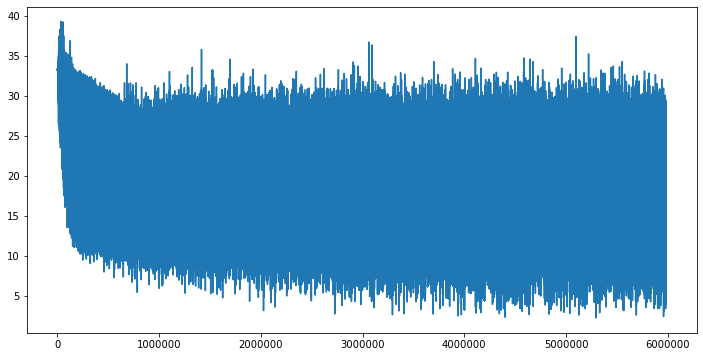

In [23]:
plt.figure(figsize=(12,6))
plt.plot(losses[::10])

In [24]:
def smoothed_losses(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
      z = decay * last + (1 - decay) * x[t]
      y[t] = z / (1 - decay ** (t + 1))
      last = z
    return y

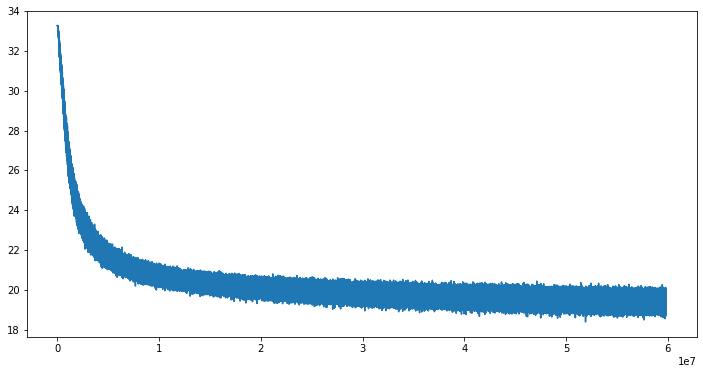

In [25]:
plt.figure(figsize=(12,6))
plt.plot(smoothed_losses(losses))

In [26]:
W1_emb = W1 # матрица эмбедингов на основе W1
W2_emb = W2.T # матрица эмбедингов на основе W2
W1_W2_avg_emb = (W1_emb + W2_emb) / 2 # матрица эмбедингов на основе усреднения W1 и W2
W1_W2_concat_emb = np.hstack([W1_emb, W2_emb]) # матрица эмбедингов конкатенировынных W1 и W2

In [27]:
np.save('W1_w2v.npy', W1_emb)
np.save('W2_w2v.npy', W2_emb)

In [28]:
# список слов для проверки образуемых ими кластеров в двумерном пространстве
words_to_check = ['russia', 'china', 'italy', 'brazil', 'australia', 'egypt', 
                  'monday', 'sunday', 'king', 'queen',
                  'audi', 'toyota', 'ford', 'ferrari',
                  'tokyo', 'berlin', 'boston', 'baghdad',
                  'river', 'creek', 'lake', 'mountain',
                  'green', 'red', 'white', 'winter', 'summer',
                  'snow', 'rain', 'weather', 'woman', 'man',
                 ]

In [29]:
# проверка, что для всех этих слов имеются эмбединги
for word in words_to_check:
    try:
        word2index[word]
    except:
        print(word)

In [30]:
from adjustText import adjust_text # позволяет печатать на графики слова без наложения друг на друга

In [31]:
def plot_embeddings(W_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Params:
            W_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    plt.figure(figsize=(10,10))
    x = [W_reduced[word2ind[word], 0] for word in words]
    y = [W_reduced[word2ind[word], 1] for word in words]
    plt.scatter(x, y, marker='x', color='red')
    texts = [plt.text(x[i], y[i], words[i], ha='center', va='center') for i in range(len(words))]
    adjust_text(texts) # позволяет печатать на графики слова без наложения друг на друга
    plt.axis('equal')
    plt.show()

    # ------------------

In [32]:
from sklearn.manifold import TSNE

In [33]:
# Сжатие матрицы эмбедингов W1 до двух измерений с помощью TSNE
W1_reduced = TSNE(n_components=2, perplexity=5, verbose=0, n_jobs=-1, random_state=42).fit_transform(W1_emb)

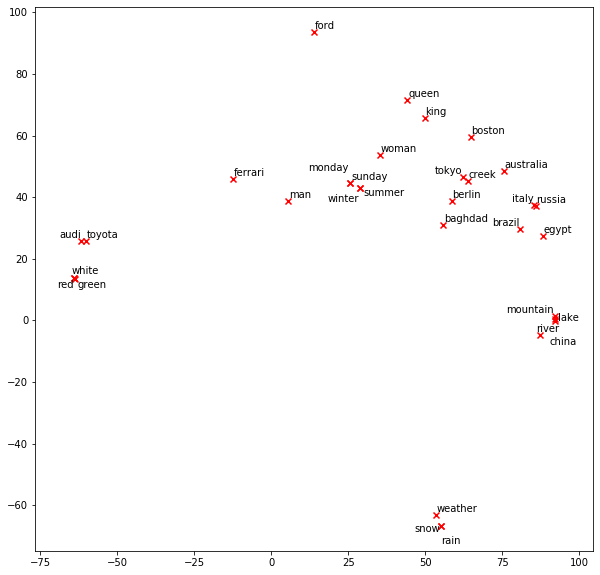

In [34]:
plot_embeddings(W1_reduced, word2index, words_to_check)

Кластеризация в двумерном пространстве - не идеальна. Некоторые категории перемешались. Но есть и хорошо изолированные кластеры: цвета, погода.

In [35]:
W2_reduced = TSNE(n_components=2, perplexity=5, verbose=0, n_jobs=-1, random_state=42).fit_transform(W2_emb)

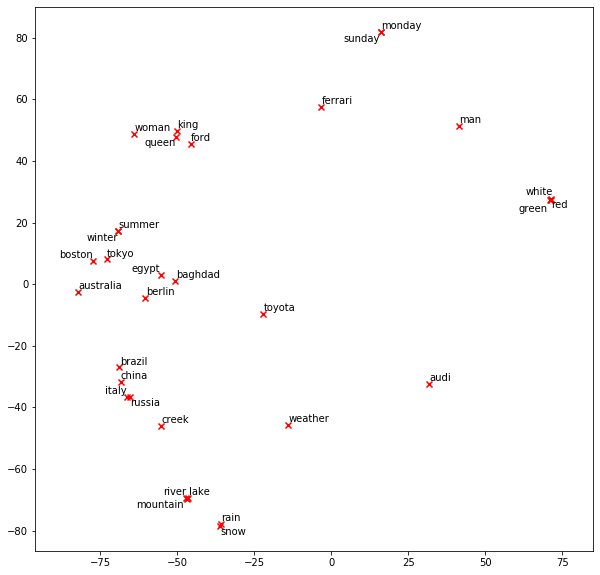

In [56]:
plot_embeddings(W2_reduced, word2index, words_to_check)

Схожая с W1 ситуация.

In [36]:
W1_W2_avg_reduced = TSNE(n_components=2, perplexity=5, verbose=0, n_jobs=-1, random_state=42).fit_transform(W1_W2_avg_emb)

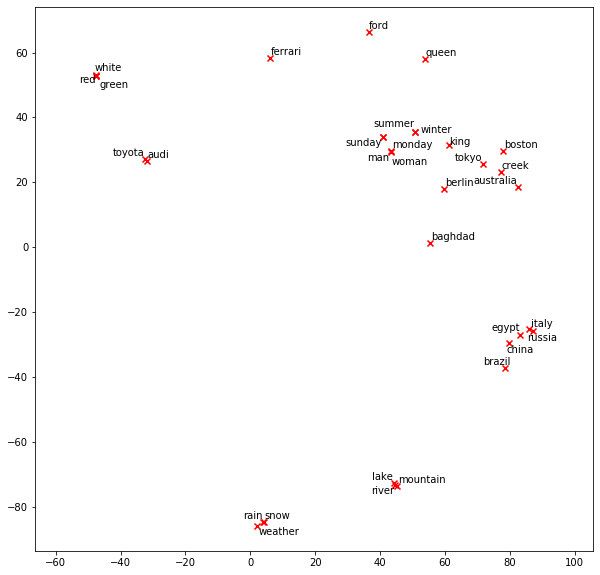

In [37]:
plot_embeddings(W1_W2_avg_reduced, word2index, words_to_check)

Аналогично предыдущим двум.

In [38]:
W1_W2_concat_reduced = TSNE(n_components=2, perplexity=5, verbose=0, n_jobs=-1, random_state=42).fit_transform(W1_W2_concat_emb)

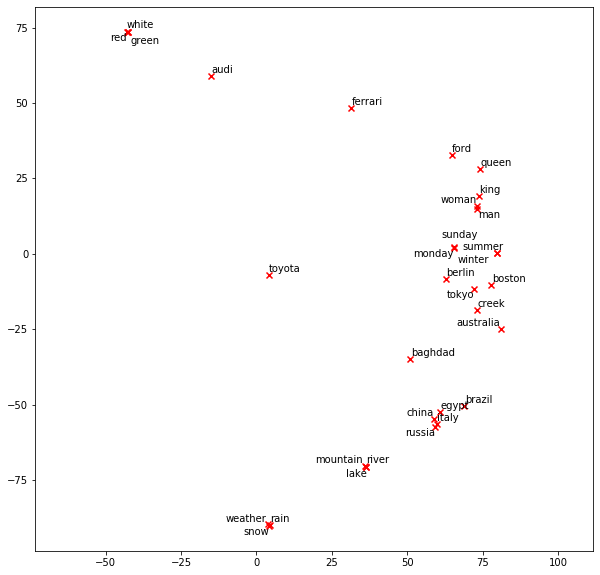

In [39]:
plot_embeddings(W1_W2_concat_reduced, word2index, words_to_check)

In [40]:
# список всех слов в словаре, для которых имеется эмбединг
list_of_words = [index2word[i] for i in range(len(index2word))] 

# списки эмбедингов
list_of_embeddings_W1 = W1_emb
list_of_embeddings_W2 = W2_emb
list_of_embeddings_W1_W2_avg = W1_W2_avg_emb
list_of_embeddings_W1_W2_concat = W1_W2_concat_emb

In [41]:
from gensim.models import KeyedVectors

In [44]:
kv_W1 = KeyedVectors(100)
kv_W2 = KeyedVectors(100)
kv_W1_W2_avg = KeyedVectors(100)
kv_W1_W2_concat = KeyedVectors(200)

kv_W1.add(list_of_words, list_of_embeddings_W1)
kv_W2.add(list_of_words, list_of_embeddings_W2)
kv_W1_W2_avg.add(list_of_words, list_of_embeddings_W1_W2_avg)
kv_W1_W2_concat.add(list_of_words, list_of_embeddings_W1_W2_concat)

kv_W1.save('w2v.kvmodel')

In [45]:
kv_W1.most_similar(['woman', 'king'], ['man'])

[('married', 0.7478463053703308),
 ('daughter', 0.7458913326263428),
 ('birth', 0.7411514520645142),
 ('elizabeth', 0.7360106706619263),
 ('prince', 0.7170559167861938),
 ('duke', 0.7056682109832764),
 ('henry', 0.7039292454719543),
 ('princess', 0.7033451199531555),
 ('emperor', 0.6920878887176514),
 ('mary', 0.6918843388557434)]

In [46]:
kv_W2.most_similar(['woman', 'king'], ['man'])

[('queen', 0.7373729348182678),
 ('elizabeth', 0.7170243263244629),
 ('scotland', 0.7076510190963745),
 ('daughter', 0.7034052014350891),
 ('mary', 0.7013669013977051),
 ('marriage', 0.6931754350662231),
 ('henry', 0.6865947842597961),
 ('throne', 0.6852452754974365),
 ('wife', 0.6819332838058472),
 ('bishop', 0.6816545724868774)]

In [47]:
kv_W1_W2_avg.most_similar(['woman', 'king'], ['man'])

[('elizabeth', 0.6950075626373291),
 ('daughter', 0.6949982643127441),
 ('queen', 0.6833165884017944),
 ('mary', 0.655434787273407),
 ('henry', 0.6538127660751343),
 ('married', 0.651190459728241),
 ('prince', 0.6362084746360779),
 ('throne', 0.6305449604988098),
 ('viii', 0.6266021728515625),
 ('eldest', 0.6210031509399414)]

In [48]:
kv_W1_W2_concat.most_similar(['woman', 'king'], ['man'])

[('elizabeth', 0.7200007438659668),
 ('daughter', 0.7184892296791077),
 ('queen', 0.7032777667045593),
 ('henry', 0.7022973895072937),
 ('mary', 0.7006558775901794),
 ('emperor', 0.6954318284988403),
 ('married', 0.6940635442733765),
 ('duke', 0.6935169100761414),
 ('prince', 0.6855721473693848),
 ('wife', 0.6767898797988892)]

Аналогии 'woman', 'king' получились лучше, чем в task_3

In [49]:
from collections import defaultdict

In [50]:
# преобразование файла 'questions_words.txt' в словарь со списком списков аналогий.
questions_words_dct = defaultdict(list)
current_key = ''
with open(os.path.join('data', 'questions_words.txt'), 'r') as f:
    for line in f.readlines():
        if line.startswith(': '):
            current_key = line[1:].strip()
        else:
            questions_words_dct[current_key].append(line.lower().split())

In [103]:
questions_words_dct['capital-common-countries'][0]

['athens', 'greece', 'baghdad', 'iraq']

In [51]:
import pandas as pd

In [95]:
def calculate_accuracy_top_1(list_of_kvs, list_of_kvs_names):
    """
    Функция подсчитывает долю правильных аналогий 
    (аналогия на первом месте в kv.most_similar) 
    из accuracy_questions_words_dct
    для всех эмбедингов из list_of_kvs.
    Результат возвращается в виде DataFrame.
    """
    list_of_accuracy_questions_words_dct = []
    for kv in list_of_kvs:
        # словарь, где ключ - категория, значение - доля правильных аналогий.
        accuracy_questions_words_dct = {} 
        # счетчик правильных аналогий суммарно для всех топиков.
        all_topics_correct = 0
        # счетчик аналогий суммарно для всех топиков.
        all_topic_overall = 0
        for topic, analogies_list in questions_words_dct.items():
            # счетчик правильных аналогий для топика topic.
            topic_correct = 0
            # счетчик аналогий для топика topic.
            topic_overall = 0
            for analogie in analogies_list:
                pos1, neg1, neg2, pos2 = analogie
                try:
                    if kv.most_similar([pos1, pos2], [neg1], 1)[0][0] == neg2:
                        topic_correct += 1
                        topic_overall += 1
                    else:
                        topic_overall += 1
                except:
                    pass
            all_topics_correct += topic_correct
            all_topic_overall += topic_overall
            accuracy_questions_words_dct[topic] = topic_correct / topic_overall * 100
        accuracy_questions_words_dct['overall'] = all_topics_correct / all_topic_overall * 100
        list_of_accuracy_questions_words_dct.append(accuracy_questions_words_dct)
    return pd.DataFrame(list_of_accuracy_questions_words_dct, index=list_of_kvs_names).T

In [53]:
results_df_top_1 = calculate_accuracy_top_1([kv_W1, kv_W2, kv_W1_W2_avg, kv_W1_W2_concat], 
                                ['W1', 'W2', 'W1_W2_avg', 'W1_W2_concat']
)

In [54]:
def highlight_max(s):
    '''
    выделяет максимальное значение в s красным.
    '''
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

In [55]:
results_df_top_1.style.apply(highlight_max, axis=1)

,W1,W2,W1_W2_avg,W1_W2_concat
capital-common-countries,14.593301,6.220096,15.789474,13.875598
capital-world,4.397310,1.293326,3.155717,2.741852
currency,0.943396,1.886792,1.886792,0.943396
city-in-state,3.510972,1.003135,4.702194,2.194357
family,47.426471,19.485294,36.397059,36.029412
gram1-adjective-to-adverb,4.585799,0.591716,3.550296,3.550296
gram2-opposite,8.333333,1.923077,4.487179,4.487179
gram3-comparative,8.049242,4.545455,8.428030,7.196970
gram4-superlative,6.277056,2.813853,5.844156,6.060606
gram5-present-participle,21.997622,11.890606,17.122473,17.835910


Как видно для разных категорий лучше работают разные эмбединги. В среднем, лучший результат у эмбединга W1.

In [65]:
def calculate_accuracy_top_5(list_of_kvs, list_of_kvs_names):
    """
    Функция подсчитывает долю правильных аналогий 
    (аналогия совпадает с одной из топ 5 в kv.most_similar) 
    из accuracy_questions_words_dct
    для всех эмбедингов из list_of_kvs.
    Результат возвращается в виде DataFrame.
    """
    list_of_accuracy_questions_words_dct = []
    for kv in list_of_kvs:
        # словарь, где ключ - категория, значение - доля правильных аналогий.
        accuracy_questions_words_dct = {} 
        # счетчик правильных аналогий суммарно для всех топиков.
        all_topics_correct = 0
        # счетчик аналогий суммарно для всех топиков.
        all_topic_overall = 0
        for topic, analogies_list in questions_words_dct.items():
            # счетчик правильных аналогий для топика topic.
            topic_correct = 0
            # счетчик аналогий для топика topic.
            topic_overall = 0
            for analogie in analogies_list:
                pos1, neg1, neg2, pos2 = analogie
                try:
                    if neg2 in [x[0] for x in kv.most_similar([pos1, pos2], [neg1], 5)]:
                        topic_correct += 1
                        topic_overall += 1
                    else:
                        topic_overall += 1
                except:
                    pass
            all_topics_correct += topic_correct
            all_topic_overall += topic_overall
            accuracy_questions_words_dct[topic] = topic_correct / topic_overall * 100
        accuracy_questions_words_dct['overall'] = all_topics_correct / all_topic_overall * 100
        list_of_accuracy_questions_words_dct.append(accuracy_questions_words_dct)
    return pd.DataFrame(list_of_accuracy_questions_words_dct, index=list_of_kvs_names).T

In [66]:
results_df_top_5 = calculate_accuracy_top_5([kv_W1, kv_W2, kv_W1_W2_avg, kv_W1_W2_concat], 
                                ['W1', 'W2', 'W1_W2_avg', 'W1_W2_concat']
)

In [67]:
results_df_top_5.style.apply(highlight_max, axis=1)

,W1,W2,W1_W2_avg,W1_W2_concat
capital-common-countries,26.315789,15.311005,24.401914,22.488038
capital-world,10.191412,3.000517,7.501293,6.983963
currency,2.830189,1.886792,2.830189,1.886792
city-in-state,8.463950,3.260188,9.780564,6.645768
family,58.088235,40.441176,59.191176,53.676471
gram1-adjective-to-adverb,10.798817,4.585799,9.319527,9.763314
gram2-opposite,21.794872,3.205128,12.820513,12.179487
gram3-comparative,20.549242,9.943182,20.265152,17.424242
gram4-superlative,11.038961,5.194805,11.255411,11.471861
gram5-present-participle,32.223543,22.592152,31.272295,29.488704


Как видно для разных категорий лучше работают разные эмбединги. В среднем, лучший результат у эмбединга W1.